In [10]:
import funzioni01 as f1
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq.job import job_monitor
#from qiskit.providers.ibmq import least_busy
from copy import deepcopy
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Parameter
import time
import qiskit.quantum_info as qi
from qiskit.utils import QuantumInstance
import qiskit.ignis.mitigation.measurement as mc
#from qiskit.result import marginal_counts
from sympy import *
import numpy as np
from sympy.solvers import solve
from sympy import Symbol
import openql as ql
from sympy.physics.quantum import TensorProduct as Tp
from sympy import sqrt, cos, sin, acos, asin, atan
import numpy as np
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')


ibmqfactory.load_account:WARNING:2022-02-16 16:54:15,049: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
qr=QuantumRegister(6)
CheckC_qc=QuantumCircuit(qr,name ='CheckC')

CheckC_qc.cx(qr[3],qr[0])
CheckC_qc.cx(qr[5],qr[2])
CheckC_qc.cx(qr[3],qr[1])
CheckC_qc.cx(qr[4],qr[3])
CheckC_qc.cx(qr[3],qr[1])
CheckC_qc.cx(qr[4],qr[3])

#CheckC_qc.draw(output="mpl")

In [12]:
res=[]
qubits=[0,2,4,1,3,5]
shots=32000

for i in range(6):

    mat=np.zeros([2,2])

    for j in range(2):

        cr=ClassicalRegister(1)
        qr=QuantumRegister(7)
        qc=QuantumCircuit(qr,cr)

        #qc.reset(qr[qubits[i]])

        if j==1:
            qc.x(qr[qubits[i]])
        
        qc.measure(qr[qubits[i]],cr)

        job=execute(qc, backend=backend_sim_jakarta, shots=shots)

        aus = job.result().get_counts()
        
        if '0' in aus:
            mat[0][j]=aus['0']/shots
        
        if '1' in aus:
            mat[1][j]=aus['1']/shots
    
    res.append(Matrix(mat))

single_qubits = res[0]
for i in range(1,6):
    single_qubits=Tp(single_qubits,res[i])


In [13]:
meas_fitter=f1.calibration_measure_mitigation(qubit=[0,2,4,1,3,5],backend_calibration=backend_sim_jakarta, shots=shots)

Procedura di calibrazione in corso!
Calibrazione completata!


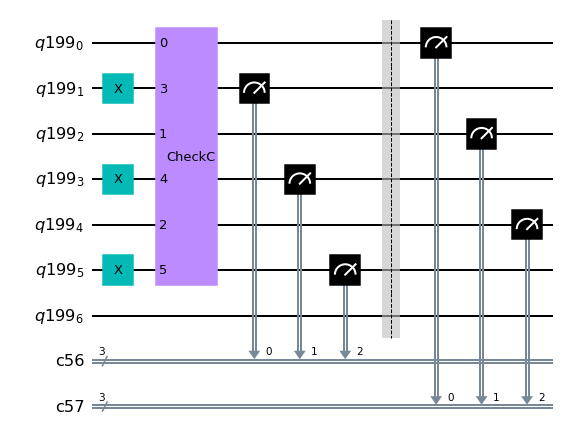

In [14]:


qubits=[1,3,5]
pos_init=f1.bin_list(3)
mat=np.zeros([2**3,2**3])
qcs=[]

for i in range(2**3):

    crq=ClassicalRegister(3)
    cra=ClassicalRegister(3)
    qr=QuantumRegister(7)
    qc=QuantumCircuit(qr,crq,cra)

    l=0
    for k in [5,3,1]:
        if pos_init[i][l]=='1':
            qc.x(qr[k])
        l+=1

    qc.append(CheckC_qc,[qr[0],qr[2],qr[4],qr[1],qr[3],qr[5]])

    qc.measure([qr[1],qr[3],qr[5]],crq)
    qc.barrier()
    qc.measure([qr[0],qr[2],qr[4]],cra)

    qcs.append(qc)

qcs[-1].draw(output="mpl")


In [15]:

job=execute(qcs, backend=backend_sim_jakarta, shots=shots)


In [19]:
raw_results=job.result()

N_ancillas=3
N_qubit=6
new_result = deepcopy(raw_results)
new_result_nm = deepcopy(raw_results)

matrix_check=np.zeros([2**3,2**3])
matrix_check_nm=np.zeros([2**3,2**3])

################create the list of the total possible outcomes
r=f1.bin_list(N_qubit=N_qubit)
r_split=[]

for j in range(2**(N_qubit)):
    X_aus=''
    X_aus+=r[j][:N_ancillas]
    X_aus+=' '
    X_aus+=r[j][N_ancillas:]
    r_split.append(X_aus)

for i in range(len(raw_results.results)): 
    
    old_counts = raw_results.get_counts(i)
    new_counts = {}
    new_counts_nm = {}

    new_result.results[i].header.creg_sizes = [new_result.results[i].header.creg_sizes[0]]
    new_result.results[i].header.clbit_labels = new_result.results[i].header.clbit_labels[0:-1]
    new_result.results[i].header.memory_slots = 3

    new_result_nm.results[i].header.creg_sizes = [new_result_nm.results[i].header.creg_sizes[0]]
    new_result_nm.results[i].header.clbit_labels = new_result_nm.results[i].header.clbit_labels[0:-1]
    new_result_nm.results[i].header.memory_slots = 3

    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0] == reg_bits[1]:
            new_counts_nm[reg_bits[1]]=old_counts[reg_key]


    new_result_nm.results[i].data.counts = new_counts_nm

    for j in range(2**N_qubit):
        if r_split[j] in old_counts.keys():
            old_counts[r[j]] = old_counts.pop(r_split[j])
    
    old_counts = meas_fitter.filter.apply(old_counts, method='least_squares')

    for j in range(2**N_qubit):
        if r[j] in old_counts.keys():
            old_counts[r_split[j]] = old_counts.pop(r[j])

    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0] in reg_bits[1]:
            new_counts[reg_bits[1]]=old_counts[reg_key]

    new_result.results[i].data.counts = new_counts

for i in range(len(raw_results.results)):

    norm=sum(new_result_nm.get_counts(i).values())
    print(norm)

    l=0
    for k in pos_init:
        if k in new_result_nm.get_counts(i):
            matrix_check_nm[l][i]=new_result_nm.get_counts(i)[k]/norm
        l+=1

    norm=sum(new_result.get_counts(i).values())
    print(norm)

    l=0
    for k in pos_init:
        if k in new_result.get_counts(i):
            matrix_check[l][i]=new_result.get_counts(i)[k]/norm
        l+=1

27134
30415.98332854493
24670
29639.30197211112
24639
29588.68151576119
22688
29202.997579247054
27891
31324.13257734677
25321
30202.404690024094
25440
30443.650939326486
23548
29965.112872343627


In [17]:
Matrix(matrix_check_nm)

Matrix([
[     0.9950984005307,   0.0054722334819619, 0.00389626202362109,                 0.0,  0.00225879315908358,  3.94929110224715e-5,                 0.0,                 0.0],
[ 0.00224810201223557,    0.992501013376571,                 0.0, 0.00286495063469676,                  0.0,  0.00252754630543817,                 0.0,                 0.0],
[0.000479103707525614,                  0.0,   0.992613336580218, 0.00520098730606488,                  0.0,                  0.0, 0.00200471698113208,                 0.0],
[                 0.0, 0.000283745439805432, 0.00174520069808028,   0.989377644569817,                  0.0,                  0.0,                 0.0, 0.00259045354170206],
[ 0.00217439374953932,                  0.0,                 0.0,                 0.0,    0.995840952278513,  0.00513407843292129, 0.00385220125786164, 4.24664515033124e-5],
[                 0.0,  0.00174300770166194,                 0.0,                 0.0,  0.00175683912373167,    0.9919434

In [18]:
Matrix(matrix_check)

Matrix([
[   0.999999999965947, 7.53238287018148e-13,                  0.0, 1.64554180673574e-14, 9.23055041868692e-14, 1.21930998363206e-14,                  0.0, 1.14405199678048e-14],
[1.65784995085527e-11,    0.999999999998144, 1.91328686429595e-12, 1.08757433129922e-12, 1.39109826913632e-15, 3.14883471442101e-13,                  0.0, 1.60280733575382e-14],
[6.84454776509203e-12, 1.59767381117551e-13,    0.999999999980014, 1.28761752416727e-13,                  0.0, 3.82615139865325e-15,                  0.0, 1.59836883674631e-14],
[2.81895150705437e-12, 5.46730264293532e-13, 1.30815470698102e-11,     0.99999999999718,                  0.0, 6.11118834356685e-15,                  0.0, 4.46077468201488e-13],
[                 0.0, 1.23062982327118e-13, 1.55559332121052e-12, 1.57190646588868e-14,    0.999999999999759,                  0.0, 3.65436538903142e-12,  2.2849080951127e-14],
[2.63856564214035e-12, 1.63213128177266e-14, 1.75474733038209e-12, 1.48221439458439e-14, 1.4684566796

In [27]:
meas_fitter.cal_matrix=matrix_check_nm0

array([[8.5518750e-01, 2.7156250e-02, 7.2750000e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.5937500e-03, 8.3543750e-01, 8.7500000e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.1062500e-02, 5.0000000e-04, 8.0156250e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.0371875e-01,
        9.3750000e-04, 6.8156250e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.3125000e-04,
        7.7081250e-01, 2.4468750e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0187500e-02,
        8.3125000e-03, 7.5384375e-01]])

In [30]:
qr_q=[1,3,5]
qr_anc=[0,2,4]

qr=qr_q+qr_anc
qr

[1, 3, 5, 0, 2, 4]